Gradient Descent: Linear Regression Example
======

A simulated variation of https://www.stat.cmu.edu/~larry/all-of-statistics/=data/faithful.dat

y = 10 * x + 30 + noise

Two model parameters:  
slope = 10  
bias = 30

Two random variables:  
x: np.random.uniform(low = 1.5, high = 5.0, size = None)  
noise: np.random.normal(loc = 0.0, scale = 5.0, size = None)

Recall that the mean squared error of the model will be the sum of reducible error and irreducible error:  
mean((actual - prediction)^2) + variance(noise)

So what is the minimum Mean Squared Error (MSE) for this problem?

---
Create the Data
-------

In [1]:
import numpy as np

count = 500

X = np.random.uniform(low = 1.5, high = 5.0, size = count).astype("float32")
Y1 = np.float32(10) * X + np.float32(30)
Y2 = np.random.normal(loc = 0.0, scale = 5.0, size = count)
Y = Y1 + Y2
X = X.reshape((X.shape[0], 1))

trnCount = int(0.8 * count)
valCount = int(0.1 * count)
tstCount = int(0.1 * count)

trnX = X[:trnCount]
valX = X[trnCount:(trnCount+valCount)]
tstX = X[(trnCount+valCount):]

trnY = Y[:trnCount]
valY = Y[trnCount:(trnCount+valCount)]
tstY = Y[(trnCount+valCount):]

print("trn shapes:", trnX.shape, trnY.shape, sep = "\t")
print("val shapes:", valX.shape, valY.shape, sep = "\t")
print("tst shapes:", tstX.shape, tstY.shape, sep = "\t")

trn shapes:	(400, 1)	(400,)
val shapes:	(50, 1)	(50,)
tst shapes:	(50, 1)	(50,)


---
Plot the Data
-------

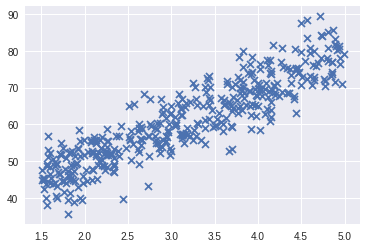

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use("seaborn")
%matplotlib inline
plt.scatter(trnX[:,0], trnY, marker = 'x')
plt.show()

---
Create the Error Surface
-------

In [3]:
# we're integrating (1/(5 - 1.5))*(((10 * x + 30)-(slope * x + bias))^2) as x goes from 1.5 to 5
# ... so that we can estimate the mean squared error for a pair of parameters
import numpy as np
X = np.linspace(8, 12, num = 41)
Y = np.linspace(28, 32, num = 41)
X, Y = np.meshgrid(X, Y)
Z = np.zeros((Y.shape[0], X.shape[0]))
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        slope = X[i,j]
        bias = Y[i,j]
        # woo hoo: closed form solution for the definite integral!
        Z[i,j] = (139 * (slope**2) - 5120 * slope + 12 * (bias**2) - 1500 * bias + 78 * slope * bias + 48100) / 12.0 + 25.0

---
Plot the Error Surface
-------

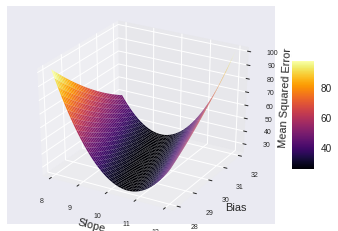

In [4]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure()
ax = fig.gca(projection = "3d")
surf = ax.plot_surface(X, Y, Z, cmap = cm.inferno, linewidth = 0, antialiased = True)
plt.xticks(np.arange(8, 13))
plt.yticks(np.arange(28, 33))
plt.tick_params(axis = "both", which = "both", labelsize = 7)
ax.set_xlabel("Slope")
ax.set_ylabel("Bias")
ax.set_zlabel("Mean Squared Error")
fig.colorbar(surf, shrink = 0.5, aspect = 5)
plt.show()

---
What is the lowest point on the error surface?
-------

In [5]:
print("params = (9.8, 29.8) in the lower, left-hand corner")
print("params = (10.2, 30.2) in the upper, right-hand corner")
print(np.rot90(Z)[18:23,18:23])

params = (9.8, 29.8) in the lower, left-hand corner
params = (10.2, 30.2) in the upper, right-hand corner
[[25.24333333 25.34333333 25.46333333 25.60333333 25.76333333]
 [25.02583333 25.06083333 25.11583333 25.19083333 25.28583333]
 [25.04       25.01       25.         25.01       25.04      ]
 [25.28583333 25.19083333 25.11583333 25.06083333 25.02583333]
 [25.76333333 25.60333333 25.46333333 25.34333333 25.24333333]]


---
Create the Model
-------

In [6]:
import tensorflow
from tensorflow.keras import models, layers, optimizers
tensorflow.random.set_seed(1)

model = models.Sequential()
model.add(layers.Dense(1, input_shape = (trnX.shape[1],), activation = "linear"))
model.summary()
model.compile(loss = "mse", optimizer = optimizers.SGD(), metrics = [ "mse" ])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


---
Prediction for a Single Example (forward propagation)
-------

In [7]:
old_weights = model.get_weights()
print(old_weights)
print(model.predict(trnX[:1]))
prediction = old_weights[0][0,0] * trnX[0,0] + old_weights[1][0]
print(prediction)

[array([[-1.1600207]], dtype=float32), array([0.], dtype=float32)]
1/1 [==============================] - 1s 746ms/step
[[-2.497444]]
-2.497444


---
Train on a Single Example (backward propagation)
-------

In [8]:
old_weights = model.get_weights()
model.fit(trnX[:1], trnY[:1], epochs = 1, batch_size = 1)
new_weights = model.get_weights()
print(new_weights[0] - old_weights[0])
print(new_weights[1] - old_weights[1])

1/1 [==============================] - 0s 184ms/step - loss: 2647.8889 - mse: 2647.8889
[[2.2156944]]
[1.0291528]


In [9]:
# recall:
#     derivative((actual - activation)^2, activation) = 2 * (activation - actual)
#     derivative(activation, product) = 1    # linear activation: f(x) = x
#     derviative(product, weight) = input    # bias input = 1

lr = model.optimizer.lr.numpy()    # learning rate
np1 = np.float32(1)
np2 = np.float32(2)
w_update = - lr * (np2 * ((old_weights[0][0,0] * trnX[0,0] + old_weights[1][0]) - trnY[0])) \
                * np1 \
                * trnX[0,0]
b_update = - lr * (np2 * ((old_weights[0][0,0] * trnX[0,0] + old_weights[1][0]) - trnY[0])) \
                * np1 \
                * np1
print([ w_update, b_update ])

[2.215694529384333, 1.0291528367106504]


---
Prediction for a Batch of Examples (forward propagation)
-------

In [10]:
old_weights = model.get_weights()
indices = slice(1, 5)
batch_size = indices.stop - indices.start
print(model.predict(trnX[indices]))
predictions = np.dot(trnX[indices], old_weights[0]) + old_weights[1]
print(predictions)

1/1 [==============================] - 0s 11ms/step
[[3.5465627]
 [5.654493 ]
 [4.710414 ]
 [5.1724677]]
[[3.5465627]
 [5.654493 ]
 [4.710414 ]
 [5.1724677]]


---
Train on a Batch of Examples (backward propagation)
-------

In [11]:
old_weights = model.get_weights()
model.fit(trnX[indices], trnY[indices], epochs = 1, batch_size = batch_size)
new_weights = model.get_weights()
print(new_weights[0] - old_weights[0])
print(new_weights[1] - old_weights[1])

1/1 [==============================] - 0s 73ms/step - loss: 3326.1501 - mse: 3326.1501
[[4.1516676]]
[1.1457356]


In [12]:
np2 = np.float32(2)
lr = model.optimizer.lr.numpy()    # learning rate

w_update = - lr * (np.dot(
                          np.transpose(trnX[indices]),
                          np.ones((batch_size, 1), dtype = 'float32') * np2 * (predictions - trnY[indices].reshape(batch_size, 1))
                         ) / batch_size)

b_update = - lr * (np.dot(
                          np.transpose(np.ones((batch_size, 1), dtype = 'float32')),
                          np.ones((batch_size, 1), dtype = 'float32') * np2 * (predictions - trnY[indices].reshape(batch_size, 1))
                         ) / batch_size)

print(w_update)
print(b_update)

[[4.15166795]]
[[1.1457356]]


---
Question: What's wrong with this "picture"?
-------

In [13]:
model = models.Sequential()
model.add(layers.Dense(1, input_shape = (trnX.shape[1],), activation = "linear"))
model.compile(loss = "mse", optimizer = optimizers.SGD(learning_rate = 0.1))
model.fit(trnX, trnY, validation_data = (valX, valY), epochs = 10, batch_size = 1, steps_per_epoch = 100)
print(model.get_weights())

Epoch 1/10
100/100 [==============================] - 0s 2ms/step - loss: 305479122944.0000 - val_loss: 155132837888.0000
Epoch 2/10
100/100 [==============================] - 0s 1ms/step - loss: 1284342324133888.0000 - val_loss: 6454614949888.0000
Epoch 3/10
100/100 [==============================] - 0s 1ms/step - loss: 1040694131032064.0000 - val_loss: 2717562441826304.0000
Epoch 4/10
100/100 [==============================] - 0s 1ms/step - loss: 358892208897654784.0000 - val_loss: 279896861442048.0000
Epoch 5/10
100/100 [==============================] - 0s 991us/step - loss: 5980207459589947392.0000 - val_loss: 438529836097470464.0000
Epoch 6/10
100/100 [==============================] - 0s 1ms/step - loss: 253417883649991888995352576.0000 - val_loss: 6059177683231703040.0000
Epoch 7/10
100/100 [==============================] - 0s 1ms/step - loss: 123069251290641989632.0000 - val_loss: 3656714887417053577216.0000
Epoch 8/10
100/100 [==============================] - 0s 997us/step 

---
Question: Why doesn't this have the same problem?
-------

In [14]:
model = models.Sequential()
model.add(layers.Dense(1, input_shape = (trnX.shape[1],), activation = "linear"))
model.compile(loss = "mse", optimizer = optimizers.SGD(learning_rate = 0.001))
model.fit(trnX, trnY, validation_data = (valX, valY), epochs = 10, batch_size = 1, steps_per_epoch = 100)
print(model.get_weights())

Epoch 1/10
100/100 [==============================] - 0s 2ms/step - loss: 768.8298 - val_loss: 86.1969
Epoch 2/10
100/100 [==============================] - 0s 1ms/step - loss: 91.6124 - val_loss: 56.8921
Epoch 3/10
100/100 [==============================] - 0s 1ms/step - loss: 81.7743 - val_loss: 55.9149
Epoch 4/10
100/100 [==============================] - 0s 1ms/step - loss: 79.1789 - val_loss: 54.4520
Epoch 5/10
100/100 [==============================] - 0s 1ms/step - loss: 86.1853 - val_loss: 53.3396
Epoch 6/10
100/100 [==============================] - 0s 983us/step - loss: 64.3561 - val_loss: 52.5122
Epoch 7/10
100/100 [==============================] - 0s 970us/step - loss: 70.8847 - val_loss: 51.6642
Epoch 8/10
100/100 [==============================] - 0s 980us/step - loss: 76.5160 - val_loss: 51.0429
Epoch 9/10
100/100 [==============================] - 0s 985us/step - loss: 66.9792 - val_loss: 49.1532
Epoch 10/10
100/100 [==============================] - 0s 989us/step - lo

---
Normalizing the Data
-------

In [15]:
muX = np.mean(trnX[:,0])
sigmaX = np.std(trnX[:,0])

muY = np.mean(trnY)
sigmaY = np.std(trnY)

trnX_norm = (trnX - muX) / sigmaX
trnY_norm = (trnY - muY) / sigmaY
valX_norm = (valX - muX) / sigmaX
valY_norm = (valY - muY) / sigmaY

model = models.Sequential()
model.add(layers.Dense(1, input_shape = (trnX.shape[1],), activation = "linear"))
model.compile(loss = "mse", optimizer = optimizers.SGD(learning_rate = 0.001))

model.fit(trnX_norm, trnY_norm, validation_data = (valX_norm, valY_norm), epochs = 10, batch_size = 1, steps_per_epoch = 100)
print(model.get_weights())

Epoch 1/10
100/100 [==============================] - 0s 1ms/step - loss: 3.1479 - val_loss: 2.5887
Epoch 2/10
100/100 [==============================] - 0s 980us/step - loss: 2.0955 - val_loss: 1.8193
Epoch 3/10
100/100 [==============================] - 0s 983us/step - loss: 1.3099 - val_loss: 1.3779
Epoch 4/10
100/100 [==============================] - 0s 1ms/step - loss: 0.8189 - val_loss: 1.0797
Epoch 5/10
100/100 [==============================] - 0s 970us/step - loss: 0.6574 - val_loss: 0.8692
Epoch 6/10
100/100 [==============================] - 0s 966us/step - loss: 0.5367 - val_loss: 0.7041
Epoch 7/10
100/100 [==============================] - 0s 1ms/step - loss: 0.4913 - val_loss: 0.5729
Epoch 8/10
100/100 [==============================] - 0s 988us/step - loss: 0.4089 - val_loss: 0.4709
Epoch 9/10
100/100 [==============================] - 0s 1ms/step - loss: 0.3519 - val_loss: 0.4007
Epoch 10/10
100/100 [==============================] - 0s 981us/step - loss: 0.2785 - val_

---
Evaluating the Model
-------

In [16]:
tstX_norm = (tstX - muX) / sigmaX    # normalize the test data
predictions = model.predict(tstX_norm) * sigmaY + muY    # reverse the normalization
print(np.mean((tstY - predictions[:,0])**2))

2/2 [==============================] - 0s 2ms/step
35.088455071567594
